In [1]:
import kagglehub

from image_toolkit.clustering import evaluate_clustering_on_validation_p

# Download latest version
path = kagglehub.dataset_download("ayaroshevskiy/downsampled-imagenet-64x64")


print("Path to dataset files:", path)

/Users/igor.varha/miniconda3/envs/samp_hum_home/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/igor.varha/.cache/kagglehub/datasets/ayaroshevskiy/downsampled-imagenet-64x64/versions/1


In [2]:
path

'/Users/igor.varha/.cache/kagglehub/datasets/ayaroshevskiy/downsampled-imagenet-64x64/versions/1'

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision import models

from PIL import Image
import random
import numpy as np
from tqdm import tqdm
from pathlib import Path
import pickle


In [4]:
# Configuration
PATCH_SIZE = 4
FRAGMENTS_PER_IMAGE = 16
EMBED_DIM = 256
BATCH_SIZE = 10
EPOCHS = 10
LR = 1e-3
IMAGE_SIZE = 64
# cuda or mps or cpu
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

In [5]:
train_path = Path(path)/'train_64x64'/'train_64x64'
test_path = Path(path)/'valid_64x64/valid_64x64'
train_dataset_p = "tr_dataset.pt"
test_dataset_p = "te_dataset.pt"


In [6]:
from image_toolkit.data_processor import FragmentDataset

if Path(train_dataset_p).exists() and Path(test_dataset_p).exists():
    train_dataset = pickle.load(open(train_dataset_p, "rb"))
    test_dataset = pickle.load(open(test_dataset_p, "rb"))
else:
    test_dataset = FragmentDataset(test_path,limit=1000)
    
    pickle.dump(test_dataset, open(test_dataset_p, "wb"))
    train_dataset = FragmentDataset(train_path,limit=100000)
    pickle.dump(train_dataset, open(train_dataset_p, "wb"))
    #tmp fix
train_dataset.augment = False
test_dataset.augment = False

  8%|▊         | 99999/1281149 [05:50<1:09:01, 285.22it/s]


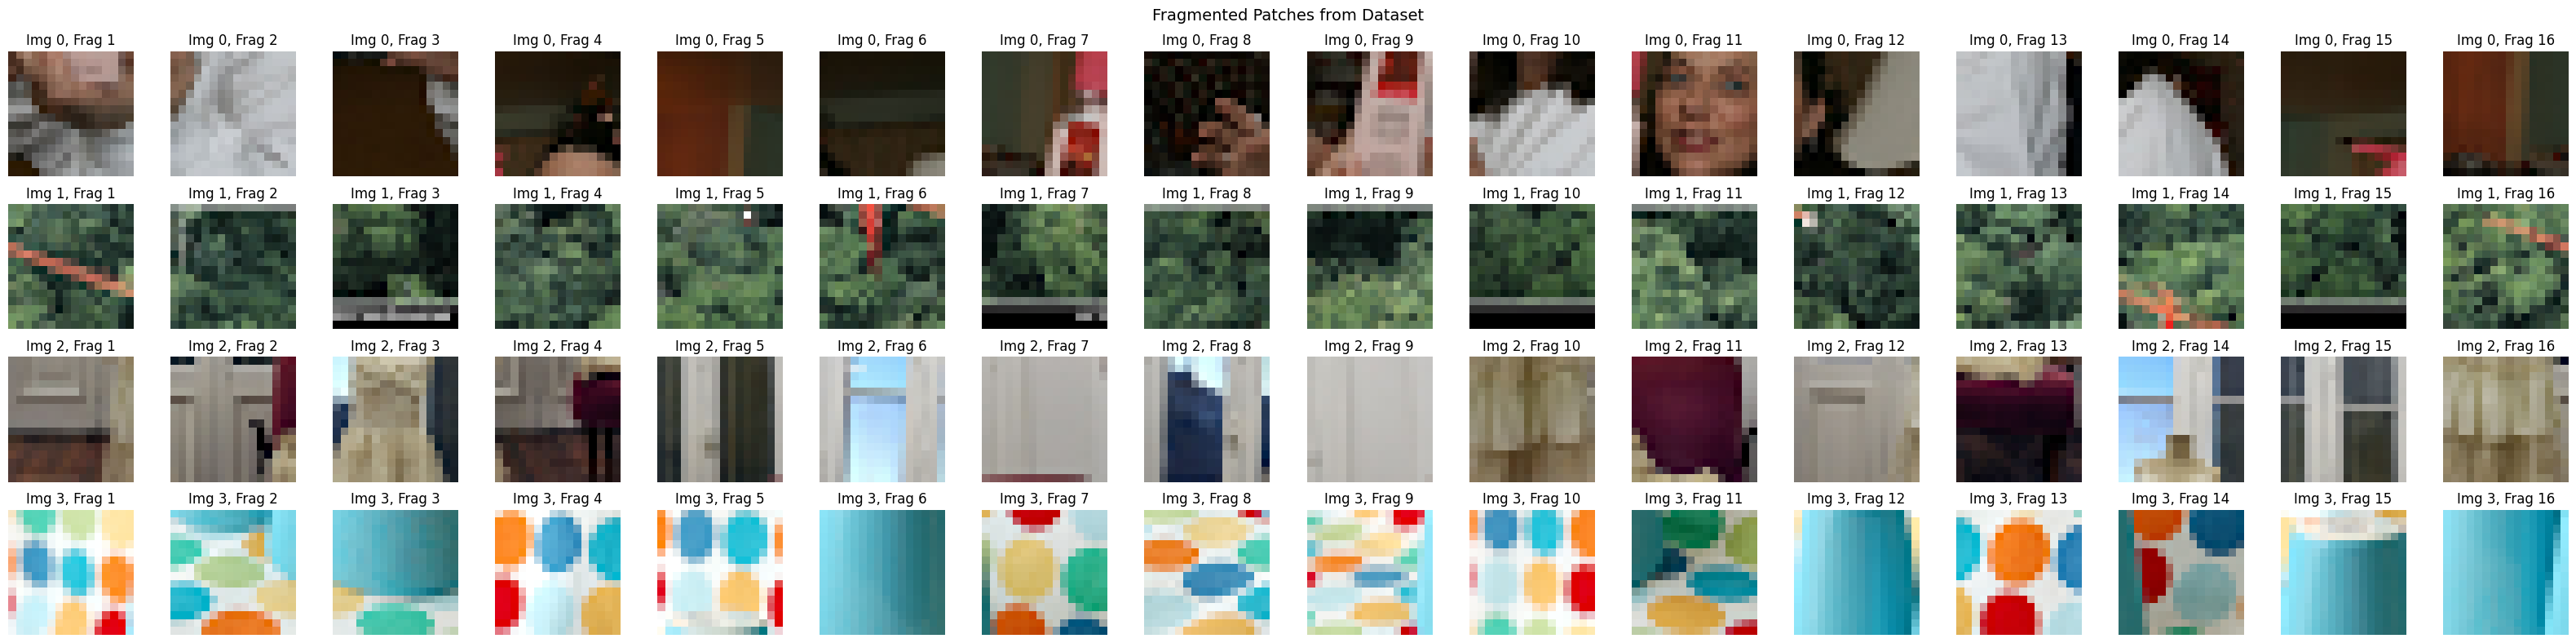

In [13]:
import matplotlib.pyplot as plt

# Visualise a few examples from the dataset
fig, axes = plt.subplots(4, FRAGMENTS_PER_IMAGE, figsize=(FRAGMENTS_PER_IMAGE * 2, 8))

for i in range(4):
    fragments, idx = train_dataset[i]
    for j in range(FRAGMENTS_PER_IMAGE):
        img = fragments[j].permute(1, 2, 0).numpy()  # CHW to HWC
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        axes[i, j].set_title(f"Img {idx}, Frag {j+1}")

plt.suptitle("Fragmented Patches from Dataset", fontsize=14)
plt.tight_layout()
plt.show()

In [14]:
dataloader_train = DataLoader(train_dataset, batch_size=10, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=10, shuffle=False)


In [15]:
from sklearn.cluster import KMeans


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.cluster import KMeans

# Now safe to import sklearn/hdbscan/etc
from sklearn.metrics import adjusted_rand_score




In [17]:
from image_toolkit.nets import TransformerPatchCluster
from torch.optim.lr_scheduler import CosineAnnealingLR

import torch.nn.functional as F

import torch

        
# Hyperparameters
EPOCHS = 20
LR = 1e-04


model = TransformerPatchCluster(embed_dim=256,nhead=8,device=DEVICE,num_layers=7).to(DEVICE) #0.72


optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

lr_scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

val_losses = model.train_model(dataloader_train,
                  dataloader_test,
                  optimizer,
                  lr_scheduler,
                  epochs=EPOCHS,
                  device=DEVICE,
                  temperature=0.33#,top_k=5
                  )



Epoch 1/200: 100%|██████████| 10000/10000 [07:09<00:00, 23.29it/s]


Epoch [1/200], Loss: 4.2282
Epoch [1/200], ARI: 0.4875


/home/varga/miniconda3/envs/test/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Model saved at epoch 1 with ARI: 0.4875
Current learning rate: [9.999854844570317e-05]


Epoch 2/200:  46%|████▌     | 4570/10000 [03:16<03:50, 23.61it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 29/200: 100%|██████████| 10000/10000 [07:08<00:00, 23.32it/s]


Epoch [29/200], Loss: 3.2278
Epoch [29/200], ARI: 0.8737


/home/varga/miniconda3/envs/test/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Model saved at epoch 29 with ARI: 0.8737
Current learning rate: [9.999533809260821e-05]


Epoch 30/200:  90%|█████████ | 9005/10000 [06:24<00:44, 22.23it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 39/200: 100%|██████████| 10000/10000 [06:53<00:00, 24.18it/s]


Epoch [39/200], Loss: 3.1844
Epoch [39/200], ARI: 0.9052


/home/varga/miniconda3/envs/test/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Model saved at epoch 39 with ARI: 0.9052
Current learning rate: [9.9994996524595e-05]


Epoch 40/200: 100%|██████████| 10000/10000 [06:56<00:00, 24.00it/s]


Epoch [40/200], Loss: 3.1812


/home/varga/miniconda3/envs/test/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [40/200], ARI: 0.8887
Current learning rate: [9.99951770997155e-05]


Epoch 41/200: 100%|██████████| 10000/10000 [07:02<00:00, 23.69it/s]


Epoch [41/200], Loss: 3.1775
Epoch [41/200], ARI: 0.9113


/home/varga/miniconda3/envs/test/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Model saved at epoch 41 with ARI: 0.9113
Current learning rate: [9.999492892546887e-05]


Epoch 43/200: 100%|██████████| 10000/10000 [07:05<00:00, 23.50it/s]


Epoch [43/200], Loss: 3.1706


/home/varga/miniconda3/envs/test/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [43/200], ARI: 0.9036
Current learning rate: [9.999501425885658e-05]


Epoch 44/200: 100%|██████████| 10000/10000 [06:55<00:00, 24.06it/s]


Epoch [44/200], Loss: 3.1685


/home/varga/miniconda3/envs/test/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [44/200], ARI: 0.9110
Current learning rate: [9.999493161670513e-05]


Epoch 46/200: 100%|██████████| 10000/10000 [07:04<00:00, 23.55it/s]


Epoch [46/200], Loss: 3.1624


/home/varga/miniconda3/envs/test/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [46/200], ARI: 0.9104
Current learning rate: [9.999493899233043e-05]


Epoch 47/200:  88%|████████▊ | 8842/10000 [06:11<00:48, 24.12it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 74/200: 100%|██████████| 10000/10000 [07:06<00:00, 23.46it/s]


Epoch [74/200], Loss: 3.1079


/home/varga/miniconda3/envs/test/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [74/200], ARI: 0.9464
Model saved at epoch 74 with ARI: 0.9464
Current learning rate: [9.999453024604258e-05]


Epoch 75/200:  34%|███▍      | 3391/10000 [02:22<04:46, 23.04it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 79/200: 100%|██████████| 10000/10000 [07:08<00:00, 23.36it/s]


Epoch [79/200], Loss: 3.1014


/home/varga/miniconda3/envs/test/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [79/200], ARI: 0.9483
Current learning rate: [9.999450834574177e-05]


Epoch 80/200: 100%|██████████| 10000/10000 [07:00<00:00, 23.78it/s]


Epoch [80/200], Loss: 3.0993


/home/varga/miniconda3/envs/test/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [80/200], ARI: 0.9499
Current learning rate: [9.999449025338836e-05]


Epoch 81/200: 100%|██████████| 10000/10000 [07:08<00:00, 23.35it/s]


Epoch [81/200], Loss: 3.1000


/home/varga/miniconda3/envs/test/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [81/200], ARI: 0.9389
Current learning rate: [9.999461677084832e-05]


Epoch 82/200: 100%|██████████| 10000/10000 [07:05<00:00, 23.48it/s]


Epoch [82/200], Loss: 3.0984


/home/varga/miniconda3/envs/test/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [82/200], ARI: 0.9487
Current learning rate: [9.99945040778298e-05]


Epoch 83/200: 100%|██████████| 10000/10000 [07:08<00:00, 23.36it/s]


Epoch [83/200], Loss: 3.0958
Epoch [83/200], ARI: 0.9508


/home/varga/miniconda3/envs/test/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Model saved at epoch 83 with ARI: 0.9508
Current learning rate: [9.999447966559127e-05]


Epoch 84/200: 100%|██████████| 10000/10000 [06:56<00:00, 23.98it/s]


Epoch [84/200], Loss: 3.0964


/home/varga/miniconda3/envs/test/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [84/200], ARI: 0.9477
Current learning rate: [9.999451517172871e-05]


Epoch 85/200: 100%|██████████| 10000/10000 [07:07<00:00, 23.38it/s]


Epoch [85/200], Loss: 3.0948


/home/varga/miniconda3/envs/test/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [85/200], ARI: 0.9552
Model saved at epoch 85 with ARI: 0.9552
Current learning rate: [9.999442767653566e-05]


Epoch 86/200: 100%|██████████| 10000/10000 [07:01<00:00, 23.70it/s]


Epoch [86/200], Loss: 3.0936


/home/varga/miniconda3/envs/test/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [86/200], ARI: 0.9580
Model saved at epoch 86 with ARI: 0.9580
Current learning rate: [9.999439590832589e-05]


Epoch 87/200:  76%|███████▋  | 7631/10000 [05:13<01:37, 24.31it/s]


KeyboardInterrupt: 

🧠 Suggestions to Improve Clustering

1. Improve Training Signal
	•	Use a stronger contrastive loss, like NT-Xent (from SimCLR), with temperature scaling and softmax.
	•	Include hard negatives instead of random ones.
	•	Increase EPOCHS (50+), and possibly reduce learning rate gradually.

2. Embed More Patch Context
	•	Use larger patches or positional encoding to capture more spatial cues.
	•	Consider a Transformer or CNN with global receptive field.

3. More Patches per Image
	•	More fragment pairs during training allow the model to learn more consistent representations per source image.

4. Clustering Setup
	•	Try tuning min_cluster_size in HDBSCAN.
	•	Alternatively, try KMeans (if you roughly know the number of source images).

In [ ]:
#from image_toolkit.nets import evaluate_clustering_on_validation
model.load_weights("best_model_epoch_86.pth")
metrics = evaluate_clustering_on_validation_p(dataloader_test, model, device=DEVICE)
print(avg_ari)

In [27]:
#Debugging

batch, idx= next(iter(dataloader_train))
images1 = batch[0]
print(images1.shape)
images2 = batch[1]

# now compute the embeddings
model.eval()
with torch.no_grad():

        # Forward pass
    embeddings1 = model(images1.to(DEVICE))
    embeddings2 = model(images2.to(DEVICE))
    # compute cosine similarity of embeddings
    print("embeddings ", embeddings1.shape)
    sim = F.cosine_similarity(embeddings1[0].unsqueeze(0), embeddings1[2].unsqueeze(0))


    print("sim 0 vs 1:", sim.item())
    sim = F.cosine_similarity(embeddings1[0].unsqueeze(0), embeddings2[6].unsqueeze(0))
    print("sim 0 vs 2:", sim.item())




torch.Size([16, 3, 16, 16])
embeddings  torch.Size([16, 256])
sim 0 vs 1: 0.9852187633514404
sim 0 vs 2: 0.31312620639801025


10 16


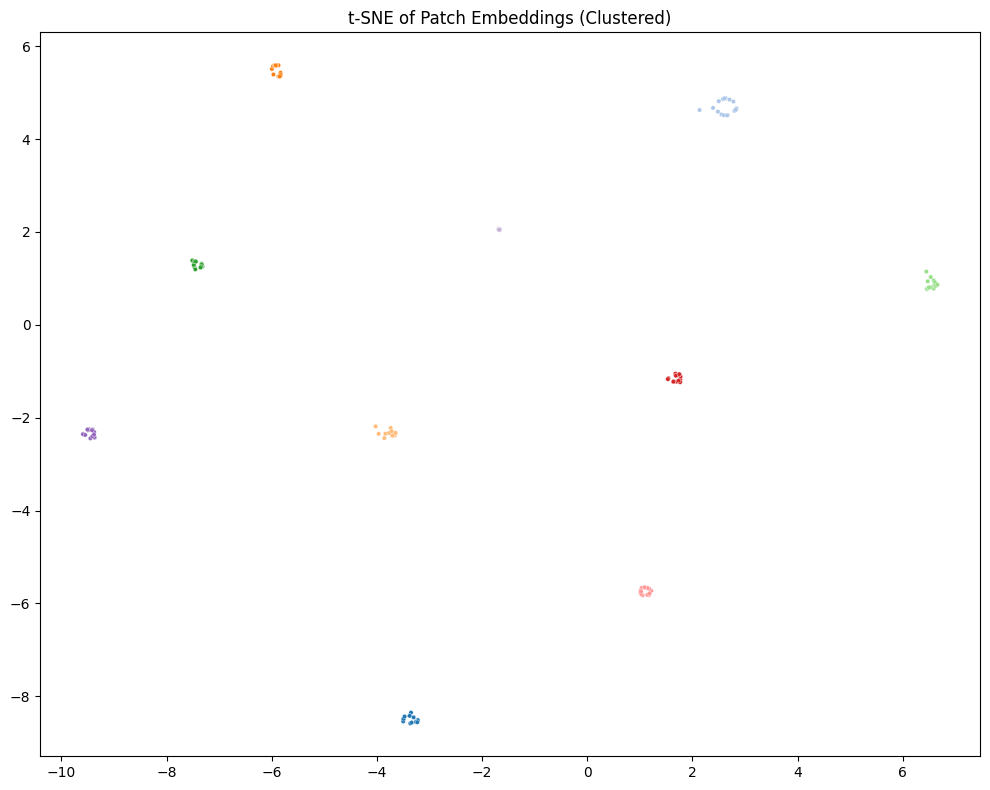

In [28]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import seaborn as sns
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering


# Reduce number of samples to avoid OOM
MAX_IMAGES = 4  # use fewer if needed
model.eval()
all_embeddings = []
all_labels = []

with torch.no_grad():
    for i, (batch, labels) in enumerate(dataloader_train):
        if len(all_labels) >= MAX_IMAGES * batch.size(1):
            break
        B, N, C, H, W = batch.shape
        print(B , N)
        batch = batch.view(B * N, C, H, W).to(DEVICE)
        labels = torch.arange(B).repeat_interleave(N).to(DEVICE)
        
        emb = model(batch).cpu()
        all_embeddings.append(emb)
        all_labels.extend([i] * emb.size(0))

# Combine
embeddings = torch.cat(all_embeddings).numpy()
labels = torch.arange(B).repeat_interleave(N)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(embeddings)

# KMeans (optional)
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=clusters, palette="tab20", s=10, legend=False)
plt.title("t-SNE of Patch Embeddings (Clustered)")
plt.tight_layout()
plt.show()

In [ ]:

from torch.utils.data import Sampler


class VariableBatchSampler(Sampler):
    def __init__(self, dataset_len, min_batch_size=2, max_batch_size=8, drop_last=False):
        self.dataset_len = dataset_len
        self.min_batch_size = min_batch_size
        self.max_batch_size = max_batch_size
        self.drop_last = drop_last
        self.epoch = 0

    def set_epoch(self, epoch):
        self.epoch = epoch

    def __iter__(self):
        # Use epoch-based seed for reproducibility per epoch
        random.seed()

        indices = list(range(self.dataset_len))
        random.shuffle(indices)

        i = 0
        while i < len(indices):
            batch_size = random.randint(self.min_batch_size, self.max_batch_size)
            batch = indices[i:i + batch_size]
            if self.drop_last and len(batch) < batch_size:
                break
            yield batch
            i += batch_size

    def __len__(self):
        avg = (self.min_batch_size + self.max_batch_size) // 2
        return self.dataset_len // avg


model.load_weights("best_model_epoch_86.pth")


def fragment_collate(batch):
    # Flatten if nested (due to __getitem__ with list input)
    if isinstance(batch[0], list):  # e.g. [[(frag, idx), (frag, idx)], [...]]
        batch = [item for sublist in batch for item in sublist]

    fragments, indices = zip(*batch)
    fragments = torch.stack(fragments)  # [B, N, C, H, W]
    indices = torch.tensor(indices)
    return fragments, indices


sampler = VariableBatchSampler(len(train_dataset), min_batch_size=4, max_batch_size=12)
dataloader_train = DataLoader(
    train_dataset,
    batch_size=1,
    collate_fn=fragment_collate,
    sampler=VariableBatchSampler(len(train_dataset), min_batch_size=4, max_batch_size=12),
)

dataloader_test = DataLoader(
    test_dataset,
    collate_fn=fragment_collate,
    batch_size=1,  # Set to 1 for sampler to control batch size
    sampler=VariableBatchSampler(len(test_dataset), min_batch_size=4, max_batch_size=12),

)
LR = 9e-5
epochs = 20
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
val_losses = model.train_model(dataloader_train,
                               dataloader_test,
                               optimizer,
                               lr_scheduler,
                               epochs=epochs,
                               device=DEVICE,
                               temperature=0.33,  #top_k=5
                               )

In [ ]:
dataloader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [ ]:
# Training loop


In [ ]:
!pip install torch_geometric

In [ ]:
labels

In [ ]:
B

In [ ]:
torch.arange(B).repeat_interleave(N)